In [16]:
import urllib.request, json 

# 5min BTC/USDT chart form Poloniex since 2017-01-01T00:00:00+00:00 till 2018-10-14T20:00:00+00:00
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1483228800&end=1539547200&period=300") as url:
    data = json.loads(url.read().decode())

In [17]:
print(data[0])

{'date': 1483228800, 'high': 965.00000066, 'low': 964.00000002, 'open': 965.00000055, 'close': 964.00000127, 'volume': 5398.83711674, 'quoteVolume': 5.59672254, 'weightedAverage': 964.64262399}


In [20]:
import csv
import numpy as np
import pandas as pd
 
df = pd.DataFrame(data=data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
        
sma = df.rolling(20).mean().values[:,4]
df = df.assign(sma=sma)
df = df.fillna(0)
df. to_csv("poloniex_usdt_btc_20170101_DOHLCV_300_sma.csv", sep=";", index=False)

print(df)

              date         open         high          low        close  \
0       1483228800   965.000001   965.000001   964.000000   964.000001   
1       1483229100   966.150000   966.150000   964.000002   964.000002   
2       1483229400   964.050000   966.149988   962.028165   964.000000   
3       1483229700   962.028165   964.000000   961.700000   962.200001   
4       1483230000   964.000011   964.677377   962.769304   962.849999   
5       1483230300   962.860013   966.149998   962.860013   966.149998   
6       1483230600   962.880000   962.880000   962.879999   962.879999   
7       1483230900   963.492610   964.519098   963.492610   964.519097   
8       1483231200   963.545457   963.545459   963.545457   963.545459   
9       1483231500   963.066163   965.668127   963.066163   965.668127   
10      1483231800   965.668127   965.668127   963.579495   963.579495   
11      1483232100   964.133267   964.133267   964.133267   964.133267   
12      1483232400   964.133268   964.

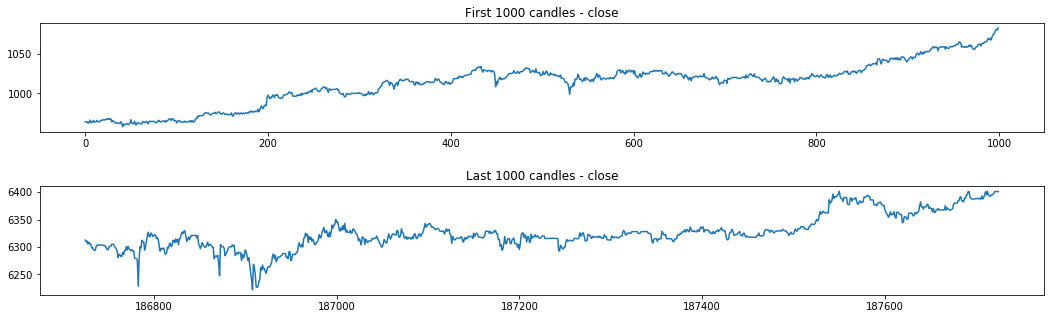

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

# data = np.genfromtxt('poloniex_usdt_btc_20170101_DOHLCV_300.csv', delimiter=';', skip_header=1)

# Visualizing chart with close prices
# These charts are ok
plt.figure(figsize=(18, 5))
plt.subplot(211).set_title('First 1000 candles - close')
plt.plot(df.iloc[:1000, 4])
plt.subplot(212).set_title('Last 1000 candles - close')
plt.plot(df.iloc[-1000:, 4])
plt.subplots_adjust(hspace=0.5)
plt.show()


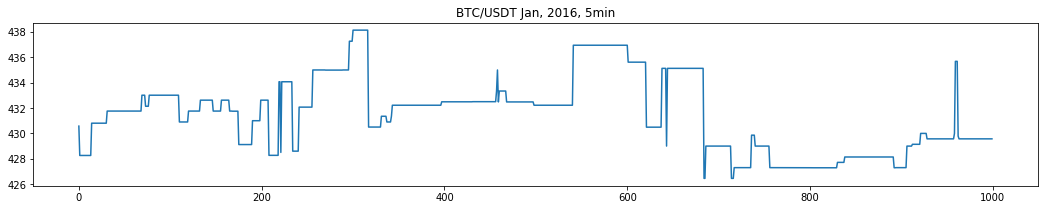

In [14]:
# Reason why we decided to use data from 2017:
# Chart from Jan, 2016 has flat parts because of low volume

# 5min BTC/USDT chart form Poloniex from Jan 01, 2016
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451606400&end=1454284800&period=300") as url:
    wrong_data = json.loads(url.read().decode())
    
wrong_close = []
for line in wrong_data:
    wrong_close.append(line['close'])

plt.figure(figsize=(18, 3))
plt.plot(wrong_close[:1000])
plt.title('BTC/USDT Jan 01, 2016, 5min')
plt.show()

In [42]:
print(df.head(20))

          date        open        high         low       close       volume  \
0   1483228800  965.000001  965.000001  964.000000  964.000001  5398.837117   
1   1483229100  966.150000  966.150000  964.000002  964.000002    84.302118   
2   1483229400  964.050000  966.149988  962.028165  964.000000  2638.676171   
3   1483229700  962.028165  964.000000  961.700000  962.200001  3415.272309   
4   1483230000  964.000011  964.677377  962.769304  962.849999    80.287691   
5   1483230300  962.860013  966.149998  962.860013  966.149998   283.301943   
6   1483230600  962.880000  962.880000  962.879999  962.879999  1397.293807   
7   1483230900  963.492610  964.519098  963.492610  964.519097    60.354671   
8   1483231200  963.545457  963.545459  963.545457  963.545459   155.101768   
9   1483231500  963.066163  965.668127  963.066163  965.668127     9.634559   
10  1483231800  965.668127  965.668127  963.579495  963.579495    55.728473   
11  1483232100  964.133267  964.133267  964.133267  

In [43]:
# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1:].astype("float")

# Ignore the first 20 row, because we are using SMA on 20 samples,
# so these incosistent values values
dataset = dataset[20:, :]


# Split the dataset into training (70%), cross validation (20%) and test (10%) set
samples_num = dataset.shape[0]

valid_split = 0.2
test_split = 0.1

dataset_train = dataset[0:int(samples_num * (1 - valid_split - test_split))]
dataset_valid = dataset[int(samples_num * (1 - valid_split - test_split)):int(samples_num * (1 - test_split))]
dataset_test = dataset[int(samples_num * (1 - test_split)):]

# Helper function for creating dataset for LSTM components
# [Description:   We want to predict the next value in time, so we have to
#                 shift the values with the 'look_back' variable]
def create_dataset_for_lstm(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

# Call the helper function for the training, cross validation and test sets,
# then format them consistently
look_back = 1
X_train, Y_train = create_dataset_for_lstm(dataset_train, look_back)
X_valid, Y_valid = create_dataset_for_lstm(dataset_valid, look_back)
X_test, Y_test = create_dataset_for_lstm(dataset_test, look_back)

X_train = X_train[:, 0, :]
X_valid = X_valid[:, 0, :]
X_test = X_test[:, 0, :]

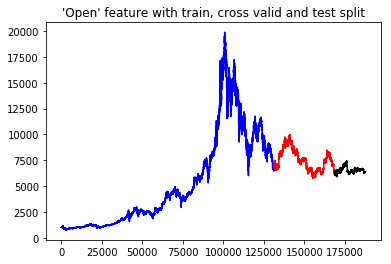

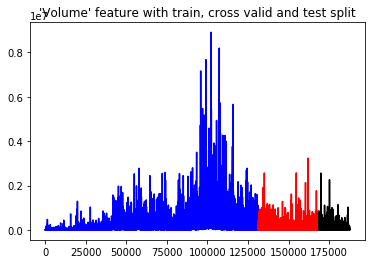

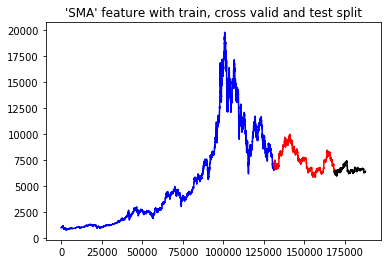

In [44]:
# Plot 'open' feature
plt.plot(dataset_train[:, 0], '-b')
plt.plot([None for i in dataset_train[:, 0]] + [x for x in dataset_valid[:, 0]], '-r')
plt.plot([None for i in dataset_train[:, 0]] + [None for x in dataset_valid[:, 0]] + [x for x in dataset_test[:, 0]], '-k')
plt.title("'Open' feature with train, cross valid and test split")
plt.show()

# Plot 'volume' feature
plt.plot(dataset_train[:, 4], '-b')
plt.plot([None for i in dataset_train[:, 4]] + [x for x in dataset_valid[:, 4]], '-r')
plt.plot([None for i in dataset_train[:, 4]] + [None for x in dataset_valid[:, 4]] + [x for x in dataset_test[:, 4]], '-k')
plt.title("'Volume' feature with train, cross valid and test split")
plt.show()

# Plot 'sma' feature
plt.plot(dataset_train[:, 5], '-b')
plt.plot([None for i in dataset_train[:, 5]] + [x for x in dataset_valid[:, 5]], '-r')
plt.plot([None for i in dataset_train[:, 5]] + [None for x in dataset_valid[:, 5]] + [x for x in dataset_test[:, 5]], '-k')
plt.title("'SMA' feature with train, cross valid and test split")
plt.show()

In [46]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print ("X_train:\n" + str(X_train))
print ("\nX_valid:\n" + str(X_valid))
print ("\nX_test:\n" + str(X_test))

X_train:
[[-0.95415766 -0.95395976 -0.95427824 -0.95404507 -0.56644329 -0.95451424]
 [-0.95414269 -0.95407918 -0.95427201 -0.95418387 -0.56768979 -0.95448987]
 [-0.95441496 -0.95391474 -0.9545365  -0.95399989 -0.55365759 -0.95445631]
 ...
 [ 0.37997143  0.37595703  0.38105321  0.37635197 -0.55570663  0.37525715]
 [ 0.37736551  0.37296636  0.37388374  0.370809   -0.48655768  0.37550816]
 [ 0.37226574  0.37032182  0.37549413  0.37379979 -0.4599442   0.37574829]]

X_valid:
[[ 0.36859052  0.36909319  0.37153028  0.37357603 -0.42658362  0.37593845]
 [ 0.37347934  0.37456905  0.37826728  0.37803965 -0.33330969  0.37601593]
 [ 0.37567881  0.37355301  0.37844464  0.37805126 -0.45042247  0.37626236]
 ...
 [ 0.26634139  0.26254525  0.27073322  0.26666022 -0.56705614  0.27301583]
 [ 0.26630809  0.26254525  0.2706998   0.26639436 -0.56322747  0.27221751]
 [ 0.26697931  0.26316245  0.2713735   0.26727954 -0.55876462  0.27144107]]

X_test:
[[ 0.27030884  0.26731794  0.27471534  0.27108892 -0.5531453